**Importer les principales bibliotheques**

In [9]:
import os
from os import listdir
from os.path import isfile, join
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve2d
from os import makedirs
from IPython.display import clear_output



**Classe Fuzzy C-Means**

In [48]:
class FCM():
    def __init__(self, image, image_bit, n_clusters, m, epsilon, max_iter):


        if np.ndim(image) != 2:
            raise Exception("<image> doit etre en 2D (image en niveaux de gris).")
        if n_clusters <= 0 or n_clusters != int(n_clusters):
            raise Exception("<n_clusters> doit etre positif.")
        if m < 1:
            raise Exception("<m> doit etre >= 1.")
        if epsilon <= 0:
            raise Exception("<epsilon> doit etre > 0")

        self.image = image
        self.image_bit = image_bit
        self.n_clusters = n_clusters
        self.m = m
        self.epsilon = epsilon
        self.max_iter = max_iter
        self.shape = image.shape
        self.X = image.flatten().astype('float')
        self.numPixels = image.size

        # Initialize attributes
        self.image = image
        self.image_bit = image_bit
        self.n_clusters = n_clusters
        self.m = m
        self.epsilon = epsilon
        self.max_iter = max_iter

        self.shape = image.shape
        self.X = image.flatten().astype('float')
        self.numPixels = image.size

    def initial_U(self):
        '''Initialisation de la matrice d'appartenance U'''
        U = np.zeros((self.numPixels, self.n_clusters))
        idx = np.arange(self.numPixels)
        for ii in range(self.n_clusters):
            idxii = idx % self.n_clusters == ii
            U[idxii, ii] = 1
        return U

    def update_U(self):

        c_mesh, idx_mesh = np.meshgrid(self.C, self.X)
        power = 2. / (self.m - 1)
        p1 = abs(idx_mesh - c_mesh) ** power
        p2 = np.sum((1. / abs(idx_mesh - c_mesh)) ** power, axis=1)
        return 1. / (p1 * p2[:, None])

    def update_C(self):
        '''Calcul des centroides'''
        numerator = np.dot(self.X, self.U ** self.m)
        denominator = np.sum(self.U ** self.m, axis=0)
        return numerator / denominator

    def form_clusters(self, save_path=None):
        '''Iterative training '''
        if save_path:
            os.makedirs(save_path, exist_ok=True)

        d = 100
        self.U = self.initial_U()
        i = 0
        while True:
            self.C = self.update_C()
            old_u = np.copy(self.U)
            self.U = self.update_U()
            d = np.sum(abs(self.U - old_u))
            print("Iteration %d : " % (i))

            # Show and save intermediate result after each iteration
            result = self.deFuzzify().reshape(self.shape).astype('int')
            plt.figure(figsize=(6, 6))
            plt.imshow(result, cmap='viridis')
            plt.title(f'Segmentation at Iteration {i}')
            plt.axis('off')
            plt.savefig("/content/segmentation_iterations/"+ f'segmentation_iter_{i}.png')

            # Save the figure if a save path is specified
            if save_path:
              plt.show()
              plt.savefig("/content/segmentation_iterations/"+ f'segmentation_iter_{i}.png')

            clear_output(wait=True)

            if d < self.epsilon or i > self.max_iter:
                break
            i += 1

        # Store the final segmented image
        self.segmentImage()

    def deFuzzify(self):

        return np.argmax(self.U, axis=1)

    def segmentImage(self):
        '''Segment image based on max weights'''
        result = self.deFuzzify()
        self.result = result.reshape(self.shape).astype('int')
        return self.result


In [49]:
def main(IMG_PATH, OUTPUT_PATH, num_bit, num_cluster, fuzziness, epsilon, max_iteration, plot_show=False, plot_save=False):

    OUTPUT_PLOT_PATH = os.path.join(OUTPUT_PATH, 'segmentation')
    files = [f for f in listdir(IMG_PATH) if isfile(join(IMG_PATH, f))]
    i=0
    for file in files:
        target_img_path = os.path.join(IMG_PATH, file)
        try:
            img = cv2.imread(target_img_path, cv2.IMREAD_GRAYSCALE)
            cluster = FCM(img, image_bit=num_bit, n_clusters=num_cluster, m=fuzziness, epsilon=epsilon, max_iter=max_iteration)
            cluster.form_clusters()
            result = cluster.result

            if plot_show:
                i=i+1
                fig = plt.figure(figsize=(12, 8), dpi=100)
                ax1 = fig.add_subplot(1, 2, 1)
                ax1.imshow(img, cmap='gray')
                ax1.set_title('Original Image')
                ax2 = fig.add_subplot(1, 2, 2)
                ax2.imshow(result)
                ax2.set_title('Segmented Image')
                plt.show()
                plt.savefig("/content/segmentation_iterations/"+ f'segmentation_iter_{i}.png')



            if plot_save:
                makedirs(OUTPUT_PLOT_PATH, exist_ok=True)
                seg_result_path = os.path.join(OUTPUT_PLOT_PATH, f"{os.path.splitext(file)[0]}.png")
                plt.imshow(result)
                plt.savefig("/content/segmentation_iterations/"+ f'segmentation_iter_{i}.png')
                plt.close()

        except IOError:
            print("Error processing file:", file)


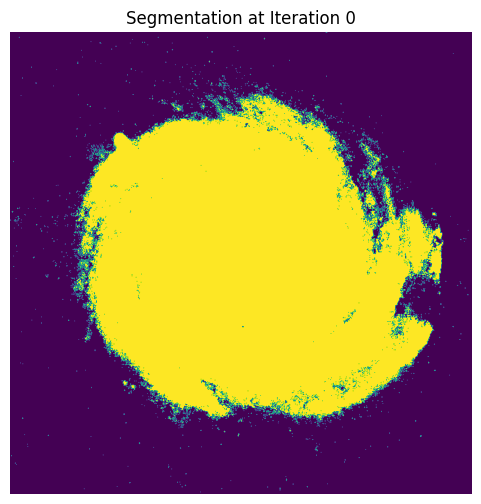

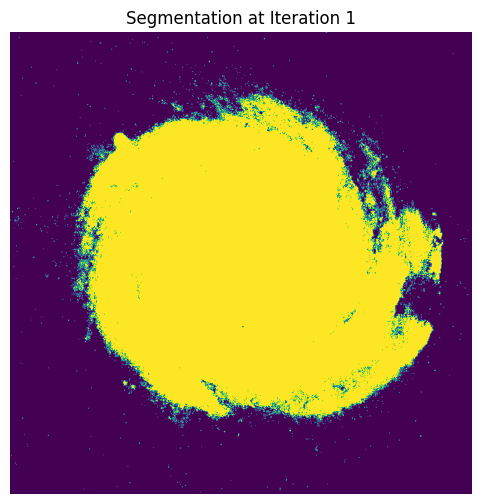

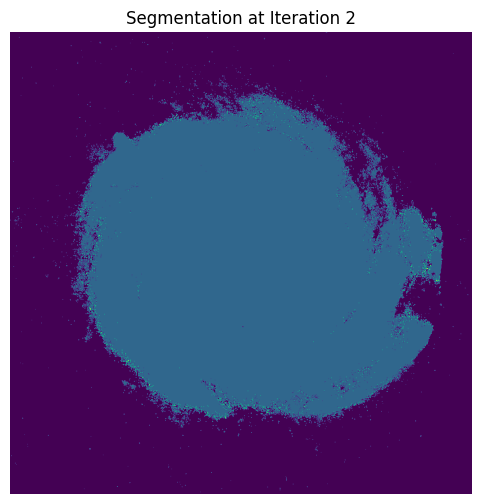

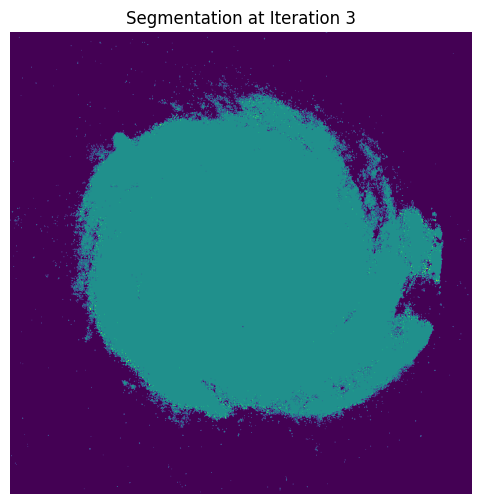

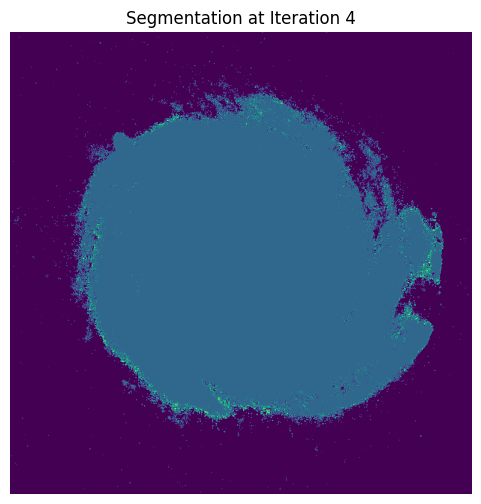

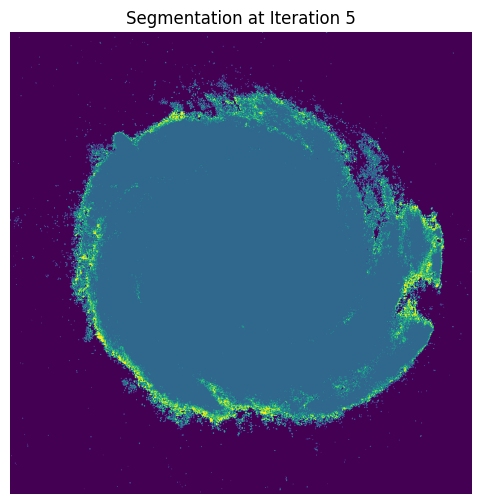

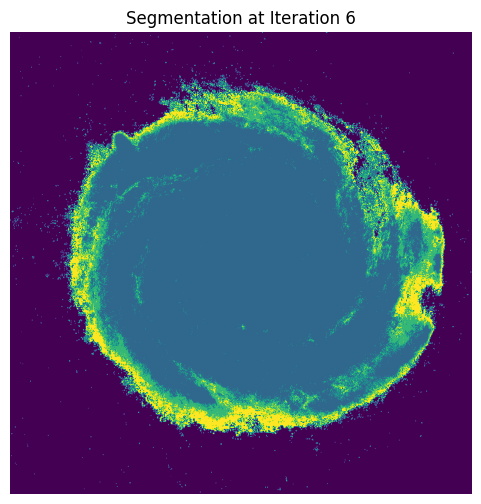

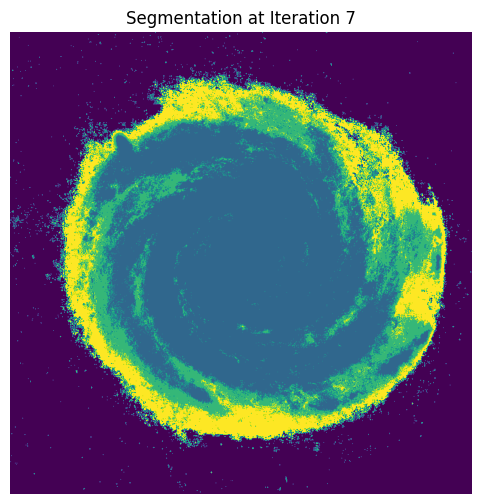

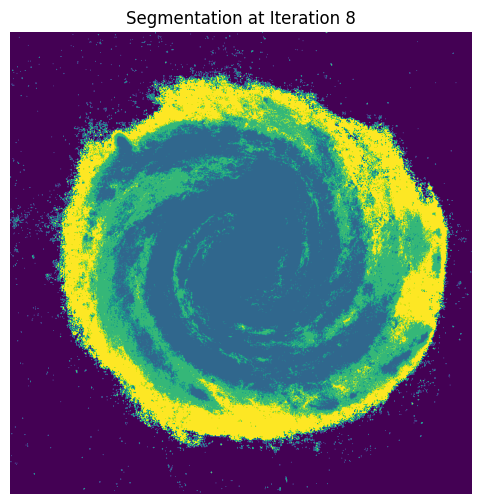

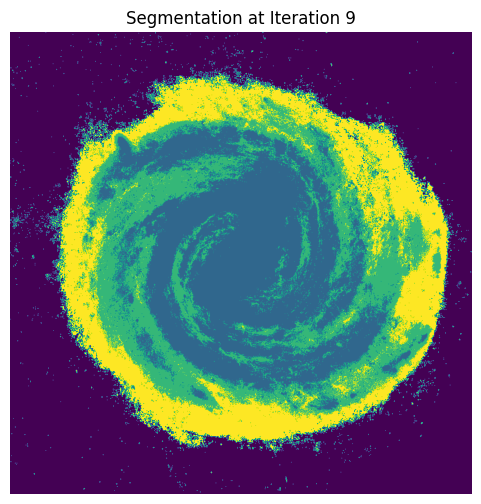

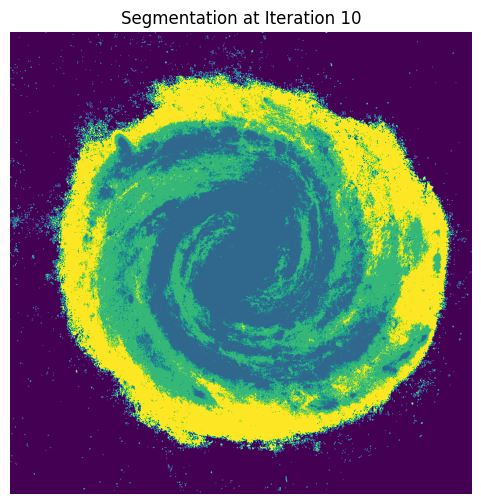

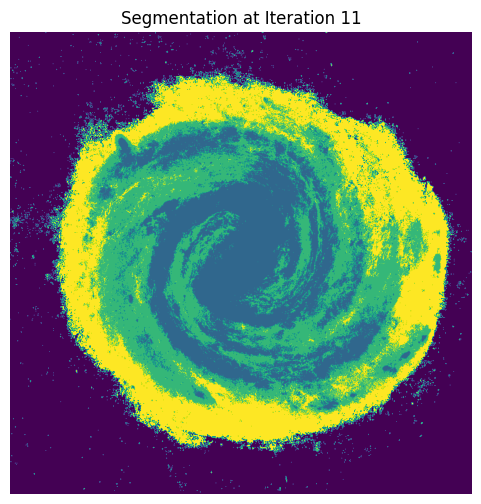

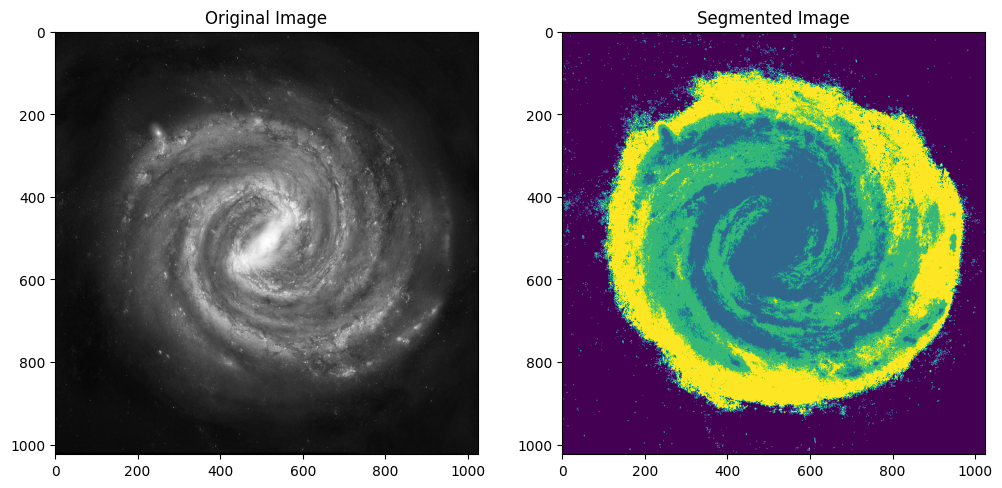

In [50]:
IMG_PATH = '/content'  #image directory
OUTPUT_PATH = '/content/'  #output directory
num_bit = 8
num_cluster = 4
fuzziness = 2
epsilon = 0.001
max_iteration = 10

# main function
main(IMG_PATH, OUTPUT_PATH, num_bit, num_cluster, fuzziness, epsilon, max_iteration, plot_show=True, plot_save=True)

